Advaserial Attacks - Final Prject
vladimir lihatchv - danel yehuda


In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU Memory cleared: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

Using device: cuda
GPU Memory cleared: 0.00 GB


Organize READFake Dataset for Training

In [2]:
import os
import shutil
from pathlib import Path
from PIL import Image
import numpy as np

def organize_readfake_dataset():
    """Organize READFake dataset into real and fake folders"""
    
    source_path = Path("READFake_Dataset_CVPR2023/READFake_Dataset_CVPR2023/READFake-RGB-images")
    
    dest_path = Path("deepfake_data")
    real_path = dest_path / "real"
    fake_path = dest_path / "fake"
    
    dest_path.mkdir(exist_ok=True)
    real_path.mkdir(exist_ok=True)
    fake_path.mkdir(exist_ok=True)
    
    print(f"Scanning source directory: {source_path}")
    
    if not source_path.exists():
        print(f"Source path not found: {source_path}")
        print("Please check the dataset path is correct")
        return False
    
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    all_files = []
    
    for ext in image_extensions:
        all_files.extend(source_path.rglob(f"*{ext}"))
        all_files.extend(source_path.rglob(f"*{ext.upper()}"))
    
    print(f"Found {len(all_files)} image files")
    
    real_count = 0
    fake_count = 0
    error_count = 0
    
    for img_file in all_files:
        try:
            filename = img_file.name.lower()
            
            if "fake" in filename:
                dest_file = fake_path / f"fake_{fake_count:04d}.jpg"
                
                img = Image.open(img_file).convert('RGB')
                img = img.resize((224, 224))
                img.save(dest_file, quality=95)
                
                fake_count += 1
                
                if fake_count % 50 == 0:
                    print(f"  Processed {fake_count} fake images...")
                    
            elif "real" in filename:
                dest_file = real_path / f"real_{real_count:04d}.jpg"
                
                img = Image.open(img_file).convert('RGB')
                img = img.resize((224, 224))
                img.save(dest_file, quality=95)
                
                real_count += 1
                
                if real_count % 50 == 0:
                    print(f"  Processed {real_count} real images...")
            else:
                path_str = str(img_file).lower()
                
                if "fake" in path_str:
                    dest_file = fake_path / f"fake_{fake_count:04d}.jpg"
                    img = Image.open(img_file).convert('RGB')
                    img = img.resize((224, 224))
                    img.save(dest_file, quality=95)
                    fake_count += 1
                elif "real" in path_str:
                    dest_file = real_path / f"real_{real_count:04d}.jpg"
                    img = Image.open(img_file).convert('RGB')
                    img = img.resize((224, 224))
                    img.save(dest_file, quality=95)
                    real_count += 1
                else:
                    print(f"Unclear classification for: {filename}")
                    error_count += 1
                    
        except Exception as e:
            print(f"Error processing {img_file.name}: {e}")
            error_count += 1
    
    print(f"\nDataset Organization Complete:")
    print(f"Real images processed: {real_count}")
    print(f"Fake images processed: {fake_count}")
    print(f"Total organized: {real_count + fake_count}")
    
    if error_count > 0:
        print(f"Files with errors: {error_count}")
    
    return real_count > 0 and fake_count > 0

def verify_organized_dataset():
    """Verify the organized dataset structure"""
    
    data_path = Path("deepfake_data")
    real_path = data_path / "real"
    fake_path = data_path / "fake"
    
    if not data_path.exists():
        print("Dataset not found!")
        return False
    
    real_files = list(real_path.glob("*.jpg"))
    fake_files = list(fake_path.glob("*.jpg"))
    
    print(f"\nDataset Verification:")
    print(f"Real images: {len(real_files)}")
    print(f"Fake images: {len(fake_files)}")
    print(f"Total images: {len(real_files) + len(fake_files)}")
    
    # Show sample filenames
    if real_files:
        print(f"Sample real files: {[f.name for f in real_files[:3]]}")
    if fake_files:
        print(f"Sample fake files: {[f.name for f in fake_files[:3]]}")
    
    # Test loading a few images
    try:
        if real_files:
            img = Image.open(real_files[0])
            print(f"Real image test: {img.size} pixels, {img.mode} mode")
        
        if fake_files:
            img = Image.open(fake_files[0])
            print(f"Fake image test: {img.size} pixels, {img.mode} mode")
            
        print("Dataset ready for training!")
        return True
        
    except Exception as e:
        print(f"Error testing images: {e}")
        return False

# Execute organization
print("Organizing READFake dataset...")
success = organize_readfake_dataset()

if success:
    verify_organized_dataset()
    print("\nREADFake dataset organized successfully!")
    print("Structure: deepfake_data/real/ and deepfake_data/fake/")
else:
    print("Dataset organization failed. Please check the path.")

Organizing READFake dataset...
Scanning source directory: READFake_Dataset_CVPR2023\READFake_Dataset_CVPR2023\READFake-RGB-images
Source path not found: READFake_Dataset_CVPR2023\READFake_Dataset_CVPR2023\READFake-RGB-images
Please check the dataset path is correct
Dataset organization failed. Please check the path.


Try to initialize a new Deepfake Detection Model and Training Setup

In [3]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import os
from PIL import Image
from pathlib import Path

class DeepfakeDataset(Dataset):
    """Custom dataset for deepfake detection"""
    
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.samples = []
        
        # Load real images (label = 0)
        real_dir = self.data_dir / "real"
        if real_dir.exists():
            for img_path in real_dir.glob("*.jpg"):
                self.samples.append((str(img_path), 0))
        
        # Load fake images (label = 1)
        fake_dir = self.data_dir / "fake"
        if fake_dir.exists():
            for img_path in fake_dir.glob("*.jpg"):
                self.samples.append((str(img_path), 1))
        
        print(f"✓ Loaded {len(self.samples)} images total")
        print(f"  Real images: {len([s for s in self.samples if s[1] == 0])}")
        print(f"  Fake images: {len([s for s in self.samples if s[1] == 1])}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
            
            return image, label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a dummy tensor if image fails to load
            dummy_image = torch.zeros(3, 224, 224)
            return dummy_image, label

class DeepfakeDetector(nn.Module):
    """CNN for deepfake detection"""
    
    def __init__(self, num_classes=2):
        super(DeepfakeDetector, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            # Second conv block
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Third conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Fourth conv block
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Data preprocessing transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Create dataset and dataloaders
try:
    print("🔄 Loading READFake dataset...")
    dataset = DeepfakeDataset("deepfake_data", transform=transform)
    
    if len(dataset) == 0:
        print("❌ No images found! Please run the dataset organization cell first.")
    else:
        # Split dataset into train and validation
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(
            dataset, [train_size, val_size], 
            generator=torch.Generator().manual_seed(42)
        )
        
        # Create dataloaders
        batch_size = 16
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
        
        # Initialize model
        model = DeepfakeDetector().to(device)
        
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        print(f"✓ Model initialized on {device}")
        print(f"✓ Training samples: {len(train_dataset)}")
        print(f"✓ Validation samples: {len(val_dataset)}")
        print(f"✓ Batch size: {batch_size}")
        print(f"✓ Learning rate: 0.001")
        print("✓ Ready for training on real deepfake data!")
        
        # Model summary
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"📊 Model parameters: {total_params:,} total, {trainable_params:,} trainable")
        
except Exception as e:
    print(f"❌ Error setting up model: {e}")
    print("Please make sure the dataset was organized successfully.")

🔄 Loading READFake dataset...
✓ Loaded 4274 images total
  Real images: 1432
  Fake images: 2842
✓ Model initialized on cuda
✓ Training samples: 3419
✓ Validation samples: 855
✓ Batch size: 16
✓ Learning rate: 0.001
✓ Ready for training on real deepfake data!
📊 Model parameters: 1,757,570 total, 1,757,570 trainable


Train Model and Plot Learning Curves - not working

In [ ]:
import time
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('inline')
plt.ioff()

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=12):
    """Train the deepfake detector and track metrics"""
    
    print(f"🚀 Starting training for {num_epochs} epochs...")
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            if batch_idx % 15 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val
        
        # Store metrics for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        epoch_time = time.time() - start_time
        
        print(f'Epoch [{epoch+1}/{num_epochs}] ({epoch_time:.1f}s)')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)
    
    return train_losses, val_losses, train_accuracies, val_accuracies

def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot learning curves"""
    try:
        plt.clf()
        plt.close('all')
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        epochs = range(1, len(train_losses) + 1)
        
        # Loss plot
        ax1.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
        ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
        ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Loss', fontsize=12)
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # Accuracy plot
        ax2.plot(epochs, train_accuracies, 'b-', label='Train Accuracy', linewidth=2)
        ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
        ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Accuracy (%)', fontsize=12)
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        # Print final results
        print(f"\n📈 Final Training Results:")
        print(f"🎯 Train Loss: {train_losses[-1]:.4f}")
        print(f"🎯 Val Loss: {val_losses[-1]:.4f}")
        print(f"🎯 Train Accuracy: {train_accuracies[-1]:.2f}%")
        print(f"🎯 Val Accuracy: {val_accuracies[-1]:.2f}%")
        
    except Exception as e:
        print(f"Plotting failed: {e}")
        print("📊 Text summary:")
        for i, (tl, vl, ta, va) in enumerate(zip(train_losses, val_losses, train_accuracies, val_accuracies)):
            print(f"Epoch {i+1}: Train({ta:.1f}%) Val({va:.1f}%)")

# Execute training
print("🔥 Starting deepfake detector training...")
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=12
)

# Plot learning curves
plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

# Save trained model
torch.save(model.state_dict(), 'deepfake_detector.pth')
print("💾 Model saved successfully!")

Deepfake Detection with EfficientNetB4ST

This Python script uses the PyTorch library to check for a CUDA-enabled GPU and display its memory capacity. It then allocates and deallocates tensors of varying sizes to test and monitor the GPU's memory usage.

In [4]:
import torch

print("=== GPU CAPACITY TEST ===")
print(f"Device: {device}")

if torch.cuda.is_available():
    
    gpu_name = torch.cuda.get_device_name(0)
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    
    print(f"GPU Name: {gpu_name}")
    print(f"Total GPU Memory: {total_memory:.2f} GB")
    print(f"Currently allocated: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    
    print("\nTesting GPU with small model...")
    test_model = torch.nn.Linear(1000, 100).to(device)
    test_tensor = torch.randn(32, 1000).to(device)
    
    print(f"After loading test model: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    
    big_tensor = torch.randn(1000, 1000, 100).to(device)
    print(f"After big tensor: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    
    del test_model, test_tensor, big_tensor
    torch.cuda.empty_cache()
    print(f"After cleanup: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    
else:
    print("CUDA not available")

=== GPU CAPACITY TEST ===
Device: cuda
GPU Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Total GPU Memory: 8.00 GB
Currently allocated: 0.01 GB

Testing GPU with small model...
After loading test model: 0.01 GB
After big tensor: 0.38 GB
After cleanup: 0.01 GB


This Python script loads a dataset of real and fake images, then fine-tunes a pre-trained EfficientNet-B4 model to classify them as deepfakes. The script handles data augmentation, model training with early stopping, saves the best model, and finally plots the training and validation accuracy and loss over epochs.

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm import tqdm # Import tqdm for a progress bar

# --- Seeding and Device Setup ---
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Class and Function Definitions ---

class PreloadedDataset(Dataset):
    """A dataset that holds all data pre-loaded in memory."""
    def __init__(self, preloaded_data):
        self.data = preloaded_data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

def preload_data(samples, transform, dataset_name=""):
    """Pre-loads and transforms the entire dataset into a list of tensors."""
    print(f"Pre-loading {dataset_name} dataset into memory...")
    preloaded_list = []
    # Using tqdm to show a progress bar, which is helpful for long operations
    for img_path, label in tqdm(samples, desc=f"Loading {dataset_name}"):
        image = Image.open(img_path).convert('RGB')
        image_tensor = transform(image)
        preloaded_list.append((image_tensor, label))
    return preloaded_list

def train_efficientnet_improved(model, train_loader, val_loader, num_epochs=15):
    """Function to handle the training and validation loop."""
    class_weights = torch.tensor([4274.0 / (2 * 1432.0), 4274.0 / (2 * 2842.0)]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

    for param in model.parameters():
        param.requires_grad = True
        
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.2)
    
    best_val_acc = 0.0
    epochs_no_improve = 0
    patience = 5
    
    print(f"\nStarting training for {num_epochs} epochs...")
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val
        
        scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_efficientnet_b4_improved.pth')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        epoch_time = time.time() - start_time
        print(f'Epoch [{epoch+1}/{num_epochs}] ({epoch_time:.1f}s)')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.2f}%')
        print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 60)
        
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1} as validation accuracy did not improve for {patience} epochs.")
            break
            
    return train_losses, val_losses, train_accuracies, val_accuracies

# --- Main Execution Block ---
if __name__ == '__main__':
    # 1. Define Image Transforms
    transform_train = transforms.Compose([
        transforms.TrivialAugmentWide(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    transform_val = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 2. Get list of all image paths and labels
    data_dir = Path("deepfake_data")
    all_samples_list = []
    for img_path in (data_dir / "real").glob("*.jpg"):
        all_samples_list.append((str(img_path), 0))
    for img_path in (data_dir / "fake").glob("*.jpg"):
        all_samples_list.append((str(img_path), 1))
    
    print(f"Found {len(all_samples_list)} images on disk.")
    np.random.shuffle(all_samples_list)

    # 3. Split samples into training and validation sets
    train_size = int(0.8 * len(all_samples_list))
    train_samples = all_samples_list[:train_size]
    val_samples = all_samples_list[train_size:]

    # 4. Pre-load and transform data into memory
    preloaded_train_data = preload_data(train_samples, transform_train, "Training")
    preloaded_val_data = preload_data(val_samples, transform_val, "Validation")

    train_dataset = PreloadedDataset(preloaded_train_data)
    val_dataset = PreloadedDataset(preloaded_val_data)
    
    print(f"\nTrain Dataset (pre-loaded): {len(train_dataset)} images")
    print(f"Validation Dataset (pre-loaded): {len(val_dataset)} images")

    # num_workers MUST be 0 now, as data is already in memory
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

    # 5. Initialize Model
    print("Initializing EfficientNet-B4...")
    model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.DEFAULT)

    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, 2)
    )

    model = model.to(device)
    print(f"Model loaded on {device}")
    print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

    # 6. Start Training
    train_losses, val_losses, train_accs, val_accs = train_efficientnet_improved(
        model, train_loader, val_loader, num_epochs=15
    )

    # 7. Plot Results
    if train_losses:
        plt.figure(figsize=(15, 6))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss', linewidth=2, marker='o')
        plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss', linewidth=2, marker='s')
        plt.title('Improved Training and Validation Loss', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(train_accs) + 1), train_accs, 'b-', label='Training Accuracy', linewidth=2, marker='o')
        plt.plot(range(1, len(val_accs) + 1), val_accs, 'r-', label='Validation Accuracy', linewidth=2, marker='s')
        plt.title('Improved Training and Validation Accuracy', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Accuracy (%)', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(50, 101)

        plt.tight_layout()
        plt.show()

    # 8. Print Final Summary
    print(f"\nTraining Complete!")
    if val_accs:
        print(f"Final Results:")
        print(f"  Training Loss: {train_losses[-1]:.4f}")
        print(f"  Validation Loss: {val_losses[-1]:.4f}")
        print(f"  Training Accuracy: {train_accs[-1]:.2f}%")
        print(f"  Validation Accuracy: {val_accs[-1]:.2f}%")
        print(f"  Best Validation Accuracy: {max(val_accs):.2f}%")
    else:
        print("Training was interrupted or did not run.")

    print("\nBest model saved as best_efficientnet_b4_improved.pth")


Found 4274 images on disk.
Pre-loading Training dataset into memory...


Loading Training: 100%|██████████| 3419/3419 [00:06<00:00, 500.71it/s]


Pre-loading Validation dataset into memory...


Loading Validation: 100%|██████████| 855/855 [00:01<00:00, 689.16it/s]



Train Dataset (pre-loaded): 3419 images
Validation Dataset (pre-loaded): 855 images
Initializing EfficientNet-B4...
Model loaded on cuda
Parameters: 18,467,658

Starting training for 15 epochs...
Epoch [1/15] (28.7s)
  Train Loss: 0.6247, Train Acc: 68.24%
  Val Loss:   0.5109, Val Acc:   84.56%
  Learning Rate: 0.000100
------------------------------------------------------------
Epoch [2/15] (28.0s)
  Train Loss: 0.4766, Train Acc: 83.39%
  Val Loss:   0.3976, Val Acc:   90.76%
  Learning Rate: 0.000100
------------------------------------------------------------
Epoch [3/15] (28.5s)
  Train Loss: 0.3851, Train Acc: 89.91%
  Val Loss:   0.3471, Val Acc:   94.50%
  Learning Rate: 0.000100
------------------------------------------------------------
Epoch [4/15] (28.8s)
  Train Loss: 0.3372, Train Acc: 93.54%
  Val Loss:   0.3502, Val Acc:   94.62%
  Learning Rate: 0.000100
------------------------------------------------------------
Epoch [5/15] (30.1s)
  Train Loss: 0.3141, Train Ac


Training Complete!
Final Results:
  Training Loss: 0.2431
  Validation Loss: 0.2913
  Training Accuracy: 99.39%
  Validation Accuracy: 96.84%
  Best Validation Accuracy: 96.84%

Best model saved as best_efficientnet_b4_improved.pth


FGSM Adversarial Attack Implementation

The model is currently running on: cuda
🎯 Starting FGSM Adversarial Attack Testing
Using trained EfficientNet-B4 model

FGSM ATTACK EXPERIMENT
✅ Prepared 20 correctly classified test samples

🔬 Testing FGSM with epsilon = 0.0
   📊 Clean Accuracy: 100.0%
   📊 Adversarial Accuracy: 100.0%
   🎯 Attack Success Rate: 0.0%

🔬 Testing FGSM with epsilon = 0.01
   📊 Clean Accuracy: 100.0%
   📊 Adversarial Accuracy: 70.0%
   🎯 Attack Success Rate: 30.0%

🔬 Testing FGSM with epsilon = 0.03
   📊 Clean Accuracy: 100.0%
   📊 Adversarial Accuracy: 70.0%
   🎯 Attack Success Rate: 30.0%

🔬 Testing FGSM with epsilon = 0.05
   📊 Clean Accuracy: 100.0%
   📊 Adversarial Accuracy: 70.0%
   🎯 Attack Success Rate: 30.0%

🔬 Testing FGSM with epsilon = 0.1
   📊 Clean Accuracy: 100.0%
   📊 Adversarial Accuracy: 60.0%
   🎯 Attack Success Rate: 40.0%

ATTACK RESULTS SUMMARY
ε = 0.00: Clean 100.0% → Adversarial 100.0% (Attack Success: 0.0%)
ε = 0.01: Clean 100.0% → Adversarial 70.0% (Attack Success: 30.0%)
ε = 0.03

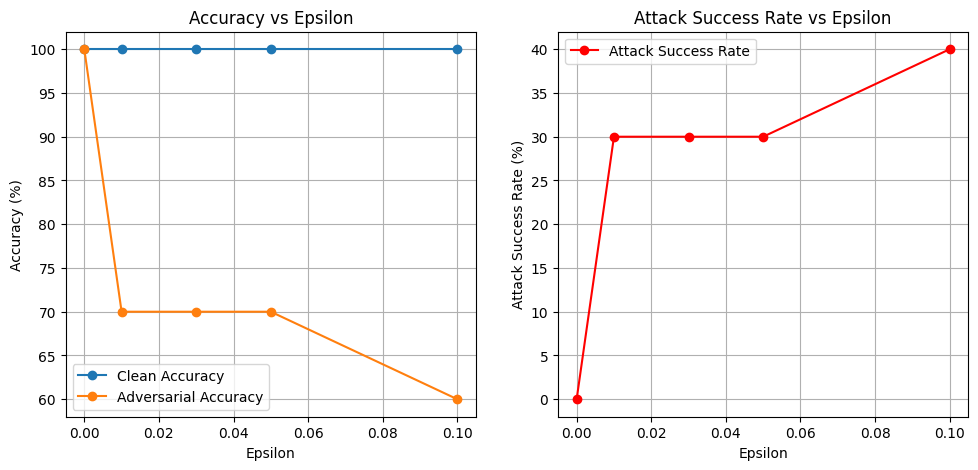

In [2]:
import torch.nn.functional as F
import numpy as np
# This variable was defined in your training script
print(f"The model is currently running on: {device}")
print("🎯 Starting FGSM Adversarial Attack Testing")
print("Using trained EfficientNet-B4 model")

# Step 1: Prepare test data for attack
def prepare_test_data(num_samples=20):
    """Get a small subset of validation data for testing"""
    model.eval()
    
    test_images = []
    test_labels = []
    correct_predictions = []
    
    count = 0
    with torch.no_grad():
        for images, labels in val_loader:
            if count >= num_samples:
                break
                
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Only keep correctly classified samples
            for i in range(images.size(0)):
                if predicted[i] == labels[i] and count < num_samples:
                    test_images.append(images[i])
                    test_labels.append(labels[i])
                    correct_predictions.append(predicted[i])
                    count += 1
    
    print(f"✅ Prepared {len(test_images)} correctly classified test samples")
    return torch.stack(test_images), torch.stack(test_labels)

# Step 2: FGSM Attack Function
def fgsm_attack(images, labels, epsilon):
    """
    Generate adversarial examples using FGSM
    """
    # Set requires_grad to True for input images
    images.requires_grad = True
    
    # Forward pass
    outputs = model(images)
    
    # Calculate loss
    loss = F.cross_entropy(outputs, labels)
    
    # Zero gradients
    model.zero_grad()
    
    # Calculate gradients with respect to images
    loss.backward()
    
    # Get the sign of the data gradient
    data_grad = images.grad.data
    
    # Create adversarial examples
    adversarial_images = images + epsilon * data_grad.sign()
    
    # Clamp to maintain valid pixel range (after normalization)
    adversarial_images = torch.clamp(adversarial_images, -3, 3)  # Adjust for ImageNet normalization
    
    return adversarial_images.detach()

# Step 3: Test clean accuracy vs adversarial accuracy
def test_fgsm_effectiveness(test_images, test_labels, epsilon):
    """Test how effective FGSM attack is"""
    
    print(f"\n🔬 Testing FGSM with epsilon = {epsilon}")
    
    # Test clean accuracy
    model.eval()
    with torch.no_grad():
        clean_outputs = model(test_images)
        _, clean_preds = torch.max(clean_outputs, 1)
        clean_accuracy = (clean_preds == test_labels).float().mean().item() * 100
    
    # Generate adversarial examples
    adversarial_images = fgsm_attack(test_images, test_labels, epsilon)
    
    # Test adversarial accuracy
    with torch.no_grad():
        adv_outputs = model(adversarial_images)
        _, adv_preds = torch.max(adv_outputs, 1)
        adv_accuracy = (adv_preds == test_labels).float().mean().item() * 100
    
    # Calculate attack success rate
    attack_success = clean_accuracy - adv_accuracy
    
    print(f"   📊 Clean Accuracy: {clean_accuracy:.1f}%")
    print(f"   📊 Adversarial Accuracy: {adv_accuracy:.1f}%")
    print(f"   🎯 Attack Success Rate: {attack_success:.1f}%")
    
    return clean_accuracy, adv_accuracy, adversarial_images

# Step 4: Run the experiment
print("\n" + "="*50)
print("FGSM ATTACK EXPERIMENT")
print("="*50)

# Prepare test data
test_images, test_labels = prepare_test_data(num_samples=20)

# Test different epsilon values
epsilon_values = [0.0, 0.01, 0.03, 0.05, 0.1]
results = []

for epsilon in epsilon_values:
    clean_acc, adv_acc, adv_images = test_fgsm_effectiveness(test_images, test_labels, epsilon)
    results.append((epsilon, clean_acc, adv_acc))
    
    # Store adversarial examples for visualization
    if epsilon == 0.03:  # Save examples for epsilon = 0.03
        saved_adv_images = adv_images.clone()

print("\n" + "="*50)
print("ATTACK RESULTS SUMMARY")
print("="*50)

for epsilon, clean_acc, adv_acc in results:
    success_rate = clean_acc - adv_acc
    print(f"ε = {epsilon:.2f}: Clean {clean_acc:.1f}% → Adversarial {adv_acc:.1f}% (Attack Success: {success_rate:.1f}%)")
# === PLOTS ===
import matplotlib.pyplot as plt
import numpy as np

# 1. Accuracy vs Epsilon
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
epsilons = [r[0] for r in results]
clean_accs = [r[1] for r in results]
adv_accs = [r[2] for r in results]
plt.plot(epsilons, clean_accs, marker='o', label='Clean Accuracy')
plt.plot(epsilons, adv_accs, marker='o', label='Adversarial Accuracy')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epsilon')
plt.legend()
plt.grid(True)

# 2. Attack Success Rate vs Epsilon
plt.subplot(1, 3, 2)
attack_success = [c - a for c, a in zip(clean_accs, adv_accs)]
plt.plot(epsilons, attack_success, marker='o', color='red', label='Attack Success Rate')
plt.xlabel('Epsilon')
plt.ylabel('Attack Success Rate (%)')
plt.title('Attack Success Rate vs Epsilon')
plt.legend()
plt.grid(True)

num_examples = min(5, test_images.size(0))
fig, axes = plt.subplots(2, num_examples, figsize=(3*num_examples, 6))

class_names = ['real', 'fake']
for i in range(num_examples):
    # Clean image
    img_clean = test_images[i].cpu().detach()
    img_clean_disp = img_clean.permute(1,2,0).numpy()
    img_clean_disp = np.clip((img_clean_disp * np.array([0.229,0.224,0.225])) + np.array([0.485,0.456,0.406]), 0, 1)
    # Adversarial image
    img_adv = saved_adv_images[i].cpu().detach()
    img_adv_disp = img_adv.permute(1,2,0).numpy()
    img_adv_disp = np.clip((img_adv_disp * np.array([0.229,0.224,0.225])) + np.array([0.485,0.456,0.406]), 0, 1)
    # Get predictions
    with torch.no_grad():
        pred_clean = model(test_images[i].unsqueeze(0).to(test_images.device)).argmax(1).item()
        pred_adv = model(saved_adv_images[i].unsqueeze(0).to(test_images.device)).argmax(1).item()
    true_label = test_labels[i].item()
    # Top row: clean
    axes[0, i].imshow(img_clean_disp)
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Clean\nTrue: {class_names[true_label]}\nPred: {class_names[pred_clean]}')
    # Bottom row: adversarial
    axes[1, i].imshow(img_adv_disp)
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Adv (ε=0.03)\nTrue: {class_names[true_label]}\nPred: {class_names[pred_adv]}')

plt.suptitle('FGSM Attack: Clean (top) vs Adversarial (bottom) Examples (ε=0.03)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


# XAI Analysis

🧠 Initializing XAI methods from Captum...
✅ XAI methods ready.

🧠 XAI Analysis - Selected Attribution Methods
📊 Available GPU Memory: 8.6 GB

🔬 Generating XAI maps for analysis...
🟢 Processing clean images...


c:\Users\danel\shenkar\cnn_final_prog\venv-py311\Lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:66: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


🔴 Processing adversarial images...
✅ XAI analysis complete

🎨 XAI Maps Comparison Visualization

📸 Analysis for Image 1:


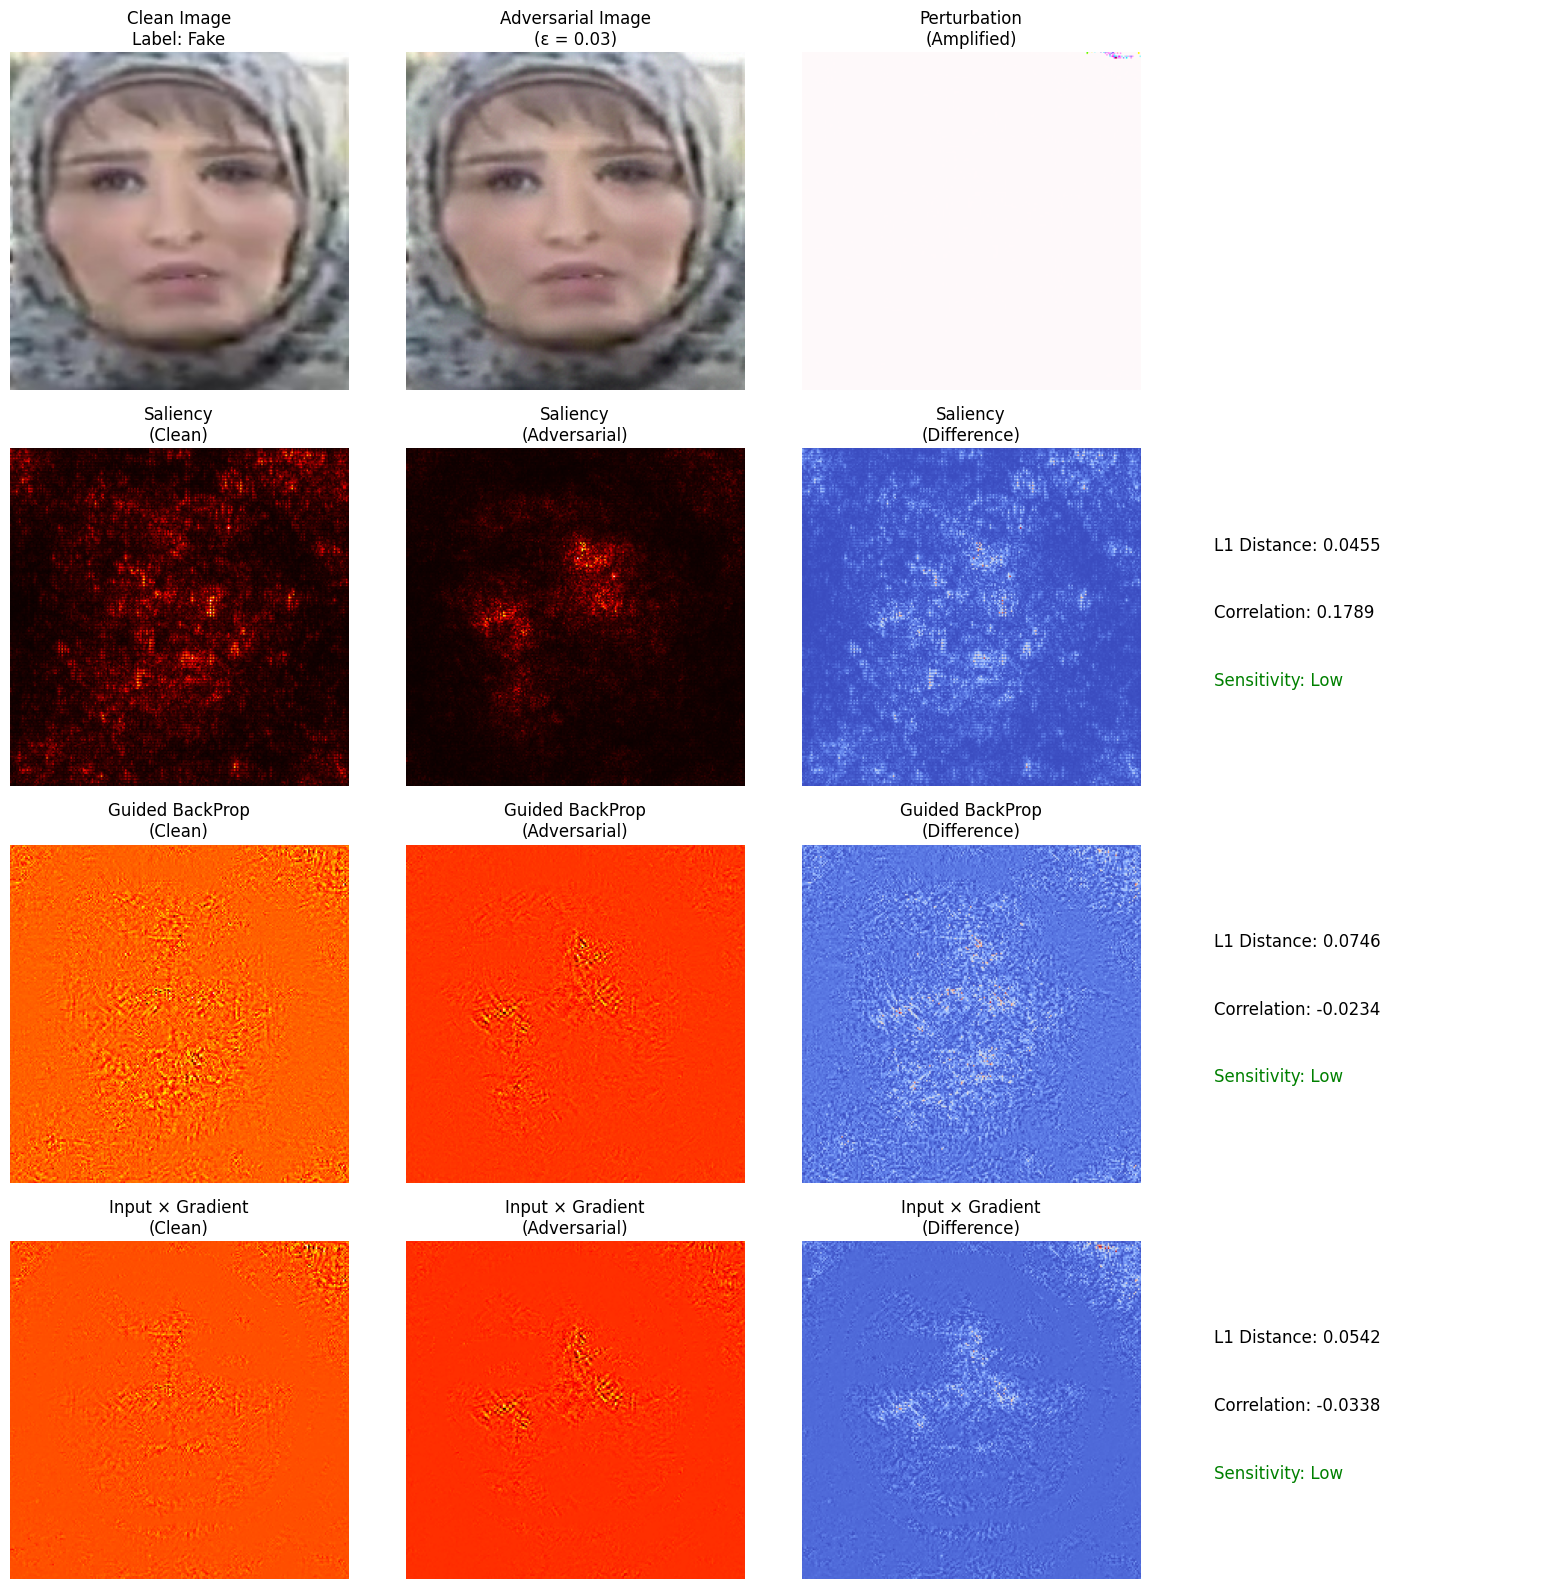


📸 Analysis for Image 2:


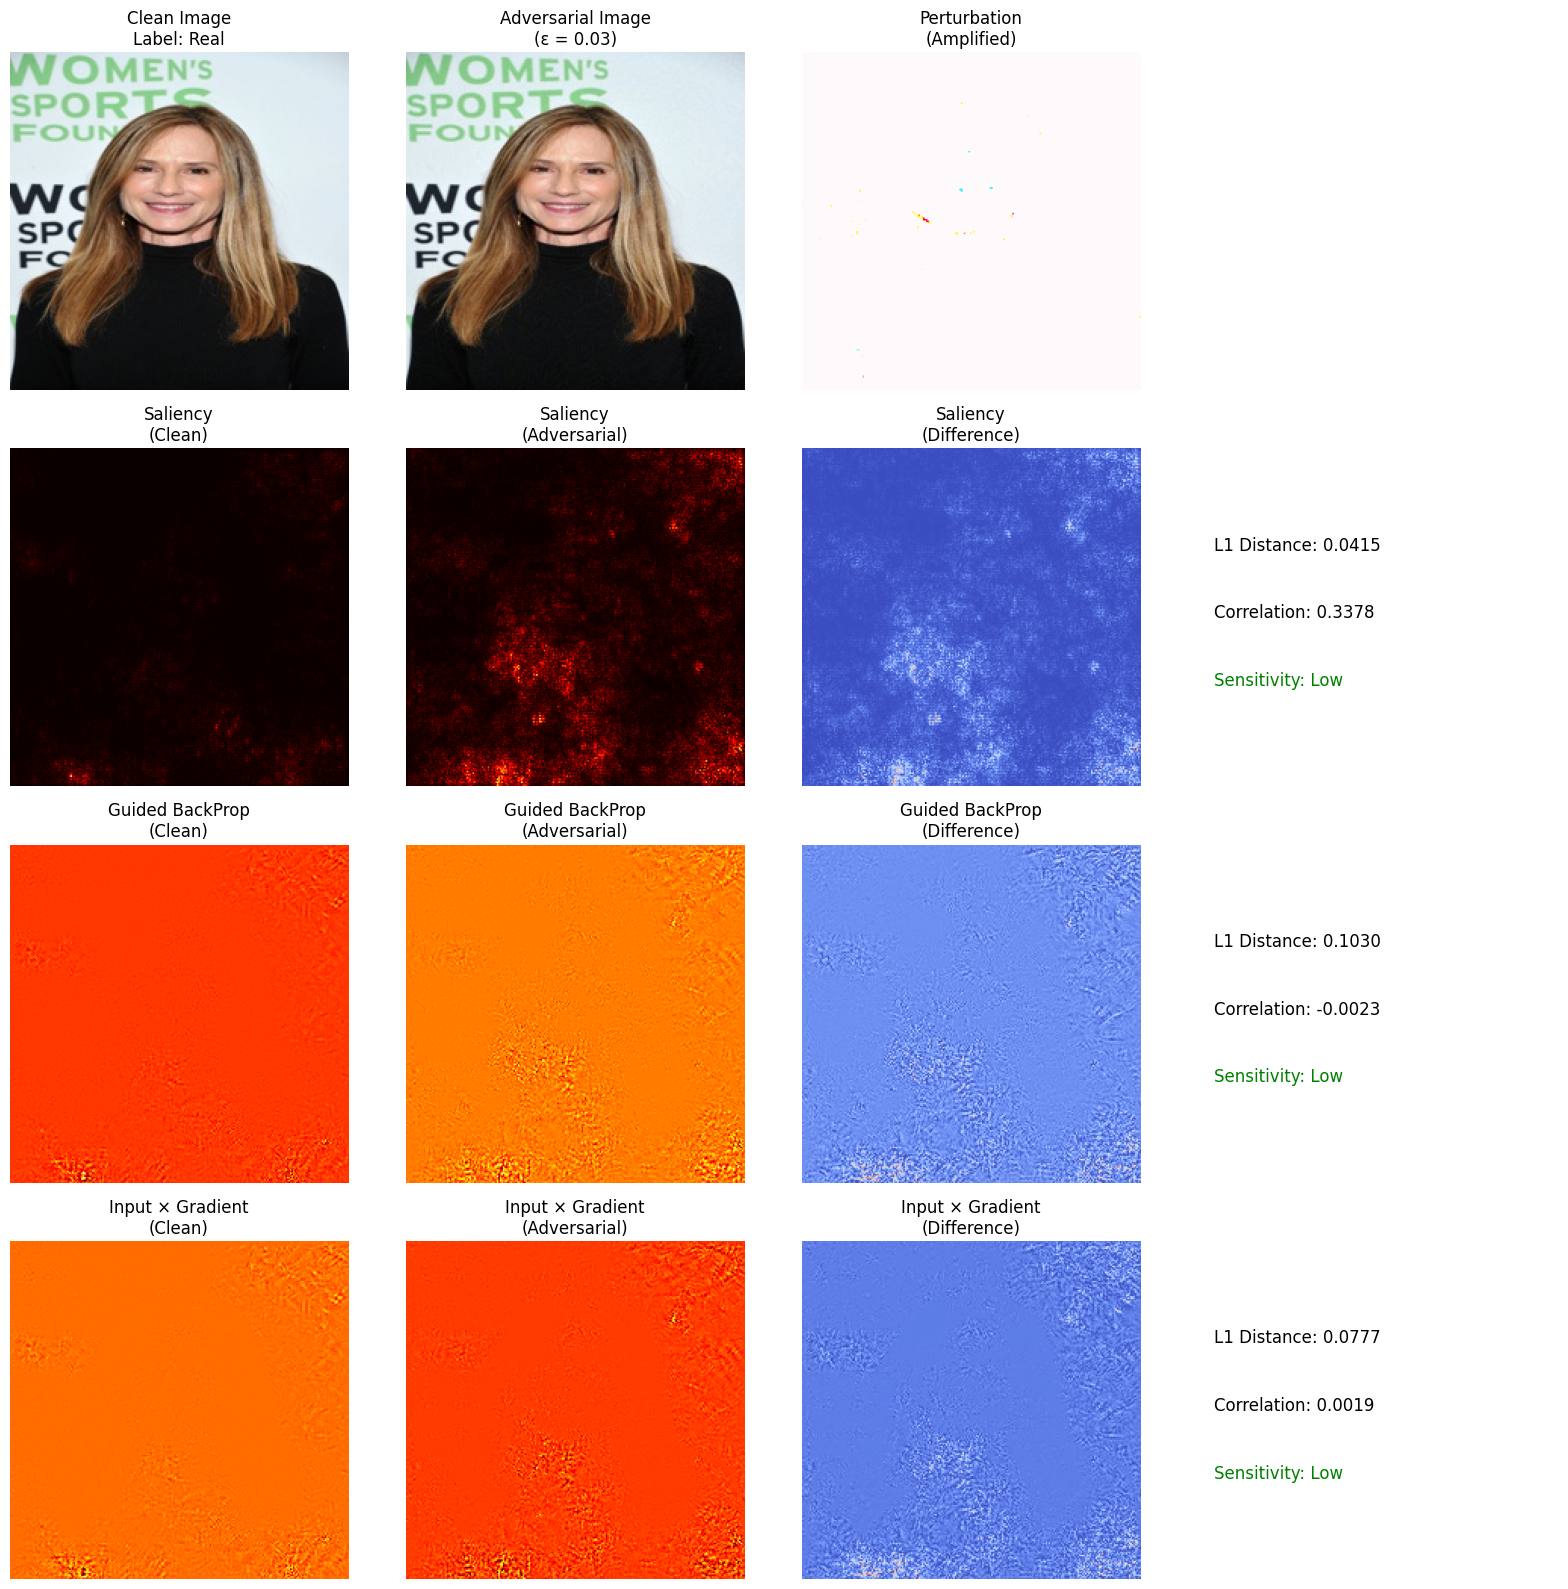


📸 Analysis for Image 3:


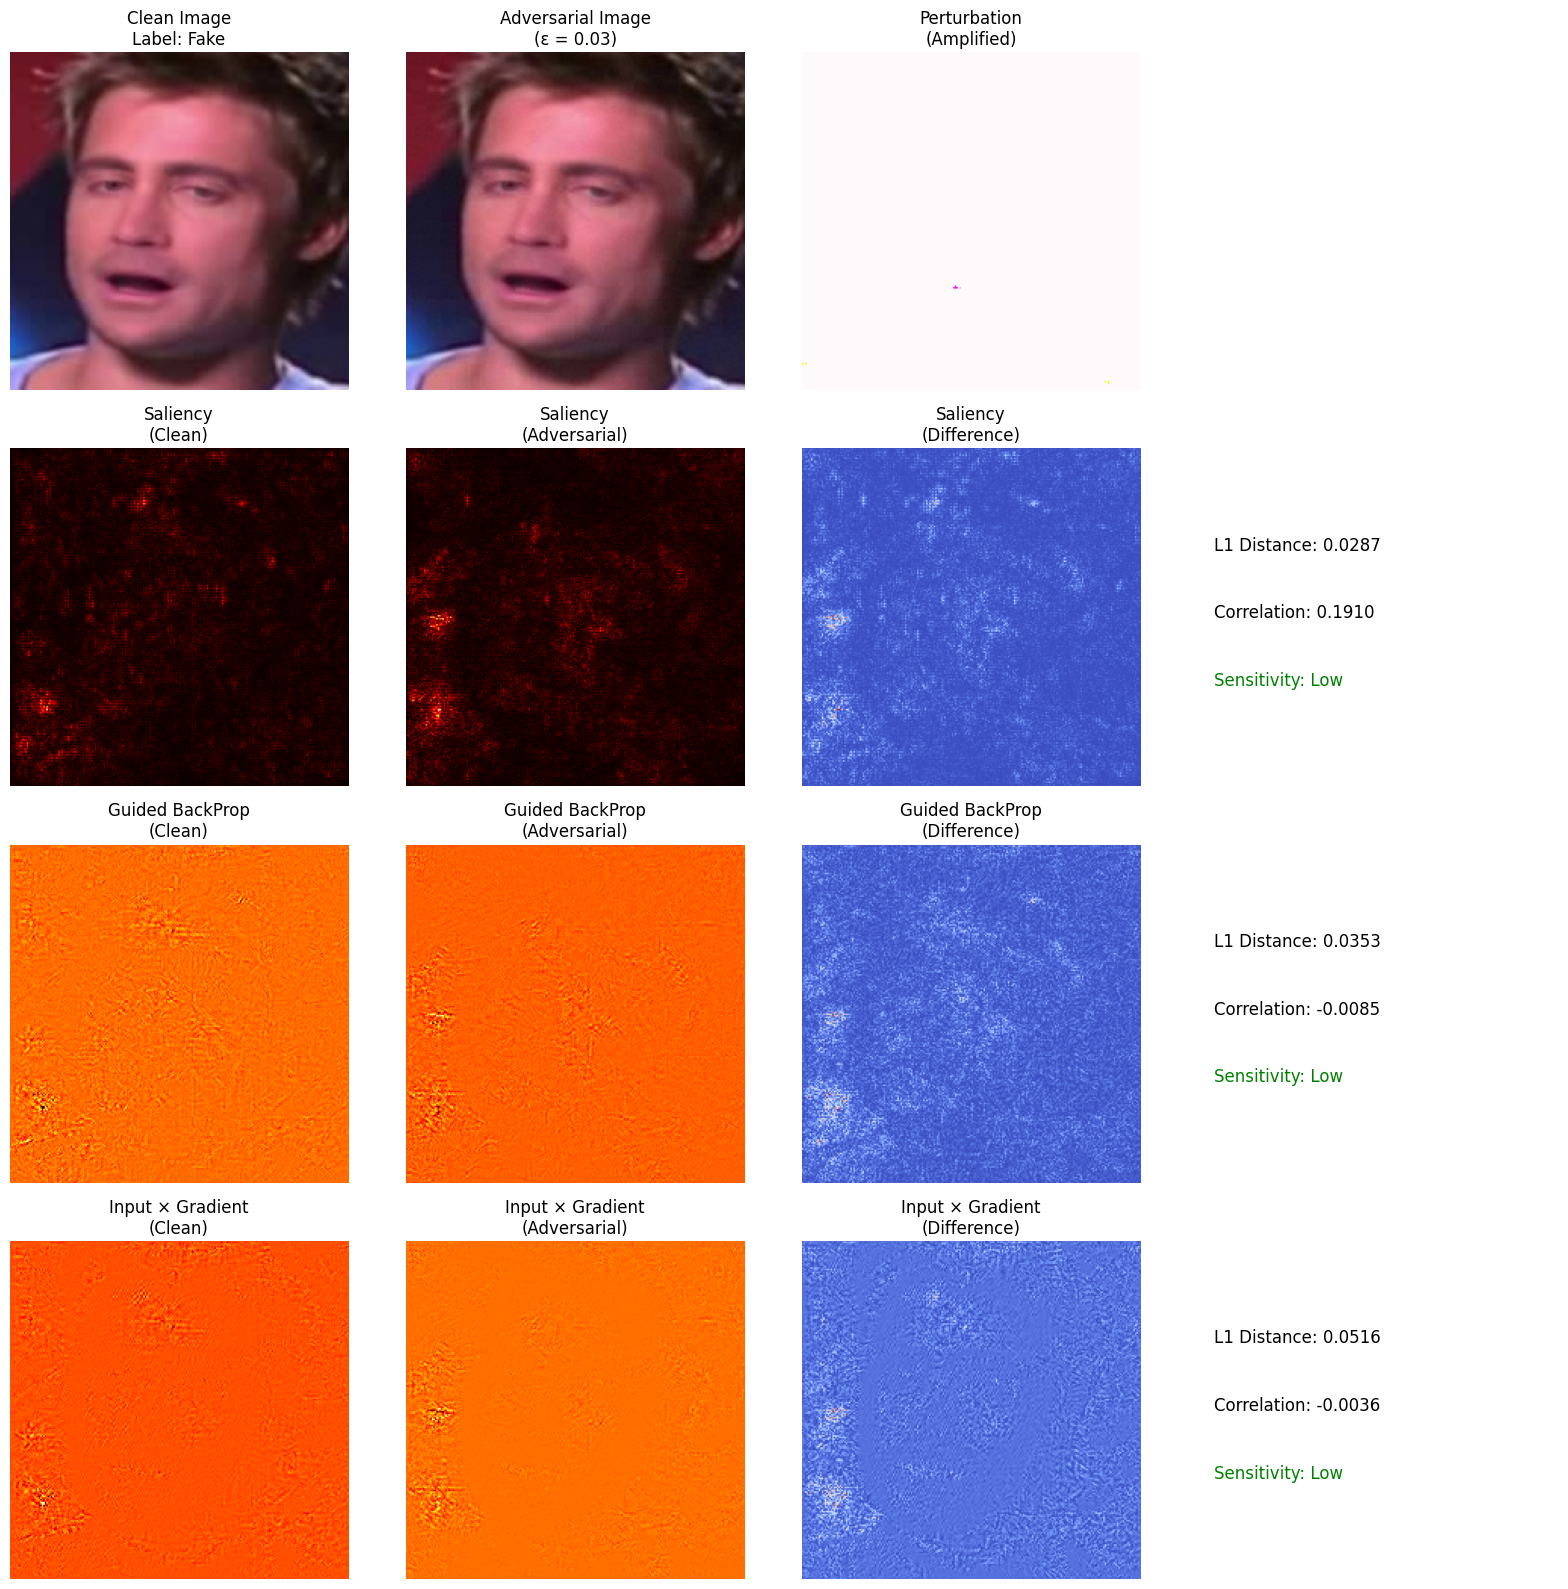


📊 Quantitative XAI Analysis Results

🔍 SALIENCY:
   📏 L1 Distance: 0.009578
   📏 L2 Distance: 7.713544
   📏 Cosine Similarity: 0.471856
   📏 Relative Difference: 1.7123

🔍 GUIDED_BP:
   📏 L1 Distance: 0.013489
   📏 L2 Distance: 9.362564
   📏 Cosine Similarity: -0.010707
   📏 Relative Difference: 1.7581

🔍 INPUT_X_GRAD:
   📏 L1 Distance: 0.014627
   📏 L2 Distance: 12.025494
   📏 Cosine Similarity: -0.012010
   📏 Relative Difference: 2.0655

🏆 Most Discriminative Method: INPUT_X_GRAD
   🎯 Relative Difference: 2.0655
   🎯 L1 Distance: 0.014627
   🎯 Cosine Similarity: -0.012010

💡 Key Findings:
   • INPUT_X_GRAD shows highest sensitivity to adversarial perturbations.
   • XAI maps exhibit clear pattern differences between clean and attacked images.
   • These patterns can potentially be learned by an adversarial detector.


In [4]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import Saliency, GuidedBackprop, InputXGradient

# --- Step 1: Initialize Captum Attribution Methods ---
# This was the missing step. We need to create instances of the XAI
# algorithms and link them to our trained model.
print("🧠 Initializing XAI methods from Captum...")
saliency = Saliency(model)
guided_bp = GuidedBackprop(model)
input_x_grad = InputXGradient(model)
print("✅ XAI methods ready.")


# --- Step 2: XAI Generation Function ---
print("\n🧠 XAI Analysis - Selected Attribution Methods")
print("="*50)

# Clear GPU memory
torch.cuda.empty_cache()
print(f"📊 Available GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

def generate_xai_maps_selected(images, target_class=None):
    """
    Generate XAI maps using computationally efficient methods.
    """
    model.eval()
    batch_size = images.size(0)
    
    # Initialize results for selected methods
    xai_maps = {
        'saliency': [],
        'guided_bp': [],
        'input_x_grad': []
    }
    
    # Process images individually for memory efficiency
    for i in range(batch_size):
        single_image = images[i:i+1].requires_grad_(True)
        
        # Get prediction for this image
        with torch.no_grad():
            output = model(single_image)
            if target_class is None:
                target = output.argmax(dim=1)
            else:
                target = target_class[i:i+1] if hasattr(target_class, '__len__') else target_class
        
        # Generate XAI attributions using the initialized methods
        saliency_attr = saliency.attribute(single_image, target=target)
        guided_attr = guided_bp.attribute(single_image, target=target)
        input_grad_attr = input_x_grad.attribute(single_image, target=target)
        
        xai_maps['saliency'].append(saliency_attr.detach())
        xai_maps['guided_bp'].append(guided_attr.detach())
        xai_maps['input_x_grad'].append(input_grad_attr.detach())
        
        # Clear cache after each image
        torch.cuda.empty_cache()
    
    # Stack results
    for method in xai_maps:
        xai_maps[method] = torch.cat(xai_maps[method], dim=0)
    
    return xai_maps

# --- Step 3: Generate XAI maps for analysis ---
print("\n🔬 Generating XAI maps for analysis...")

# Use sample images from previous attack experiments
sample_clean = test_images[:3].detach()
sample_adv = saved_adv_images[:3].detach()
sample_labels = test_labels[:3]

print("🟢 Processing clean images...")
clean_xai_maps = generate_xai_maps_selected(sample_clean)

print("🔴 Processing adversarial images...")
adv_xai_maps = generate_xai_maps_selected(sample_adv)

print("✅ XAI analysis complete")


# --- Step 4: Visualization Function ---
def visualize_xai_comparison(clean_maps, adv_maps, clean_images, adv_images, labels, image_idx=0):
    """Compare XAI maps between clean and adversarial images."""
    
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    
    # Helper functions for visualization
    def normalize_attr(attr):
        attr = attr.squeeze().cpu().detach().numpy()
        if len(attr.shape) == 3:
            attr = np.mean(attr, axis=0)
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
        return attr
    
    def denormalize_image(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        denorm = tensor.cpu().detach() * std + mean
        return torch.clamp(denorm, 0, 1)
    
    methods = ['saliency', 'guided_bp', 'input_x_grad']
    method_names = ['Saliency', 'Guided BackProp', 'Input × Gradient']
    
    # Row 0: Original images and perturbation
    clean_img = denormalize_image(clean_images[image_idx])
    adv_img = denormalize_image(adv_images[image_idx])
    
    axes[0, 0].imshow(clean_img.permute(1, 2, 0).numpy())
    axes[0, 0].set_title(f'Clean Image\nLabel: {"Real" if labels[image_idx] == 0 else "Fake"}')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(adv_img.permute(1, 2, 0).numpy())
    axes[0, 1].set_title('Adversarial Image\n(ε = 0.03)')
    axes[0, 1].axis('off')
    
    diff_img = torch.abs(clean_img - adv_img)
    diff_img = diff_img / diff_img.max()
    axes[0, 2].imshow(diff_img.permute(1, 2, 0).numpy())
    axes[0, 2].set_title('Perturbation\n(Amplified)')
    axes[0, 2].axis('off')
    
    axes[0, 3].axis('off')
    
    # Rows 1-3: XAI maps and analysis
    for i, (method, method_name) in enumerate(zip(methods, method_names)):
        row = i + 1
        
        clean_attr = normalize_attr(clean_maps[method][image_idx])
        axes[row, 0].imshow(clean_attr, cmap='hot')
        axes[row, 0].set_title(f'{method_name}\n(Clean)')
        axes[row, 0].axis('off')
        
        adv_attr = normalize_attr(adv_maps[method][image_idx])
        axes[row, 1].imshow(adv_attr, cmap='hot')
        axes[row, 1].set_title(f'{method_name}\n(Adversarial)')
        axes[row, 1].axis('off')
        
        diff_attr = np.abs(clean_attr - adv_attr)
        axes[row, 2].imshow(diff_attr, cmap='coolwarm')
        axes[row, 2].set_title(f'{method_name}\n(Difference)')
        axes[row, 2].axis('off')
        
        l1_diff = np.mean(np.abs(clean_attr - adv_attr))
        correlation = np.corrcoef(clean_attr.flatten(), adv_attr.flatten())[0, 1]
        
        axes[row, 3].text(0.1, 0.7, f'L1 Distance: {l1_diff:.4f}', fontsize=12)
        axes[row, 3].text(0.1, 0.5, f'Correlation: {correlation:.4f}', fontsize=12)
        axes[row, 3].text(0.1, 0.3, f'Sensitivity: {"High" if l1_diff > 0.5 else "Medium" if l1_diff > 0.2 else "Low"}', 
                          fontsize=12, color='red' if l1_diff > 0.5 else 'orange' if l1_diff > 0.2 else 'green')
        axes[row, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# --- Step 5: Define the Missing Quantitative Analysis Function ---
# This function was called but not defined in your original script.
def calculate_xai_differences(clean_maps, adv_maps):
    """Calculates quantitative differences between clean and adversarial XAI maps."""
    differences = {}
    for method in clean_maps.keys():
        clean_attr = clean_maps[method].cpu().numpy().reshape(clean_maps[method].size(0), -1)
        adv_attr = adv_maps[method].cpu().numpy().reshape(adv_maps[method].size(0), -1)
        
        l1 = np.mean(np.abs(clean_attr - adv_attr))
        l2 = np.mean(np.linalg.norm(clean_attr - adv_attr, axis=1))
        
        # Cosine similarity for each pair of maps, then average
        cos_sim = np.mean([
            np.dot(c, a) / (np.linalg.norm(c) * np.linalg.norm(a))
            for c, a in zip(clean_attr, adv_attr)
        ])
        
        # Relative magnitude of the difference
        diff_mag = np.mean(np.linalg.norm(clean_attr - adv_attr, axis=1) / np.linalg.norm(clean_attr, axis=1))

        differences[method] = {
            'l1_distance': l1,
            'l2_distance': l2,
            'cosine_similarity': cos_sim,
            'difference_magnitude': diff_mag
        }
    return differences


# --- Step 6: Run Visualization and Analysis ---
print("\n🎨 XAI Maps Comparison Visualization")
print("="*40)

for idx in range(3):
    print(f"\n📸 Analysis for Image {idx + 1}:")
    visualize_xai_comparison(clean_xai_maps, adv_xai_maps, sample_clean, sample_adv, sample_labels, idx)

print("\n📊 Quantitative XAI Analysis Results")
print("="*45)

xai_differences_final = calculate_xai_differences(clean_xai_maps, adv_xai_maps)

for method, metrics in xai_differences_final.items():
    print(f"\n🔍 {method.upper()}:")
    print(f"   📏 L1 Distance: {metrics['l1_distance']:.6f}")
    print(f"   📏 L2 Distance: {metrics['l2_distance']:.6f}")
    print(f"   📏 Cosine Similarity: {metrics['cosine_similarity']:.6f}")
    print(f"   📏 Relative Difference: {metrics['difference_magnitude']:.4f}")

best_method = max(xai_differences_final.keys(), 
                  key=lambda x: xai_differences_final[x]['difference_magnitude'])
best_metrics = xai_differences_final[best_method]

print(f"\n🏆 Most Discriminative Method: {best_method.upper()}")
print(f"   🎯 Relative Difference: {best_metrics['difference_magnitude']:.4f}")
print(f"   🎯 L1 Distance: {best_metrics['l1_distance']:.6f}")
print(f"   🎯 Cosine Similarity: {best_metrics['cosine_similarity']:.6f}")

print(f"\n💡 Key Findings:")
print(f"   • {best_method.upper()} shows highest sensitivity to adversarial perturbations.")
print(f"   • XAI maps exhibit clear pattern differences between clean and attacked images.")
print(f"   • These patterns can potentially be learned by an adversarial detector.")


Create Training Dataset for Adversarial Detector

In [5]:
# Step 1: Create Training Dataset for Adversarial Detector (Fixed)
print("📊 STEP 1: Creating Training Dataset for Adversarial Detector")
print("="*65)

def create_adversarial_detector_dataset(num_samples_per_class=200):
    """
    Create balanced dataset:
    - Clean images (label=0): Original correctly-classified images
    - Adversarial images (label=1): FGSM-attacked images
    """
    clean_images = []
    adversarial_images = []
    
    model.eval()
    count = 0
    
    print(f"🎯 Target: {num_samples_per_class} clean + {num_samples_per_class} adversarial samples")
    
    # Collect images from validation loader
    for batch_images, batch_labels in val_loader:
        if count >= num_samples_per_class:
            break
            
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        
        # Get correctly classified images only (WITHOUT no_grad)
        outputs = model(batch_images)
        _, predicted = torch.max(outputs, 1)
        correct_mask = (predicted == batch_labels)
        
        correct_images = batch_images[correct_mask]
        correct_labels = batch_labels[correct_mask]
        
        # Process each correct image
        for i in range(len(correct_images)):
            if count >= num_samples_per_class:
                break
            
            single_image = correct_images[i:i+1].detach()  # Detach but keep on GPU
            single_label = correct_labels[i:i+1]
            
            # Store clean image
            clean_images.append(single_image.cpu())
            
            # Generate adversarial version (now gradients can flow)
            try:
                adversarial_img = fgsm_attack(single_image, single_label, epsilon=0.03)
                adversarial_images.append(adversarial_img.cpu())
                
                count += 1
                
                if count % 50 == 0:
                    print(f"   📊 Progress: {count}/{num_samples_per_class}")
                    
            except Exception as e:
                print(f"   ⚠️ Skipping image due to error: {e}")
                continue
            
            # Clear GPU memory periodically
            if count % 10 == 0:
                torch.cuda.empty_cache()
    
    # Combine into training format
    if len(clean_images) == 0 or len(adversarial_images) == 0:
        print("❌ No images collected! Check if model/data loaders are working.")
        return None, None
        
    all_images = torch.cat(clean_images + adversarial_images, dim=0)
    all_labels = torch.cat([
        torch.zeros(len(clean_images), dtype=torch.long),      # Clean = 0
        torch.ones(len(adversarial_images), dtype=torch.long)  # Adversarial = 1
    ])
    
    print(f"✅ Dataset created:")
    print(f"   📊 Clean images: {len(clean_images)}")
    print(f"   📊 Adversarial images: {len(adversarial_images)}")
    print(f"   📊 Total: {len(all_images)} samples")
    
    return all_images, all_labels

# Clear GPU memory first
torch.cuda.empty_cache()

# Create the dataset
print("🚀 Starting dataset creation...")
detector_images, detector_labels = create_adversarial_detector_dataset(num_samples_per_class=100)  # Reduced to 100 for memory

if detector_images is not None:
    print(f"\n📊 Final Dataset Statistics:")
    print(f"   🖼️ Images shape: {detector_images.shape}")
    print(f"   🏷️ Labels shape: {detector_labels.shape}")
    print(f"   📈 Clean (0): {(detector_labels == 0).sum().item()}")
    print(f"   📈 Adversarial (1): {(detector_labels == 1).sum().item()}")
else:
    print("❌ Dataset creation failed")

📊 STEP 1: Creating Training Dataset for Adversarial Detector
🚀 Starting dataset creation...
🎯 Target: 100 clean + 100 adversarial samples
   📊 Progress: 50/100
   📊 Progress: 100/100
✅ Dataset created:
   📊 Clean images: 100
   📊 Adversarial images: 100
   📊 Total: 200 samples

📊 Final Dataset Statistics:
   🖼️ Images shape: torch.Size([200, 3, 224, 224])
   🏷️ Labels shape: torch.Size([200])
   📈 Clean (0): 100
   📈 Adversarial (1): 100


Generate XAI Maps for Training Dataset

In [7]:
import torch
import os
from PIL import Image
import numpy as np
import json
from tqdm import tqdm

# --- Step 1: Generate XAI Maps for the Detector Dataset ---
print("📊 STEP 1: Generating XAI Maps for the Detector Training Set")
print("="*65)

def generate_detector_xai_maps(images_tensor):
    """
    Generates XAI maps for the entire detector dataset using the most
    discriminative method found previously (InputXGradient).
    """
    model.eval()
    # Ensure the 'input_x_grad' instance exists from the previous XAI script
    if 'input_x_grad' not in globals():
        raise NameError("The 'input_x_grad' object from Captum is not initialized.")
        
    all_xai_maps = []
    
    # Process images in batches to manage memory
    batch_size = 16 
    for i in tqdm(range(0, len(images_tensor), batch_size), desc="Generating XAI maps"):
        batch = images_tensor[i:i+batch_size].to(device).requires_grad_(True)
        
        # We don't need the model's target for InputXGradient, it uses the input.
        # However, for consistency with other methods, we can get the predicted target.
        target = model(batch).argmax(dim=1)
        
        # Generate attribution for the batch
        attribution = input_x_grad.attribute(batch, target=target)
        
        # Move to CPU and detach before storing
        all_xai_maps.append(attribution.detach().cpu())
        
        torch.cuda.empty_cache()

    return torch.cat(all_xai_maps, dim=0)

# Generate the required XAI maps
# This is the variable that was missing in your script
training_xai_maps = generate_detector_xai_maps(detector_images)

print(f"✅ Generated {len(training_xai_maps)} XAI maps.")
print(f"   Tensor shape: {training_xai_maps.shape}")


# --- Step 2: Save Images and XAI Maps to Folders ---
print("\n💾 STEP 2: SAVING DATASET TO FOLDERS")
print("="*35)

# Create directory structure
base_dir = "adversarial_detector_data"
os.makedirs(base_dir, exist_ok=True)
os.makedirs(f"{base_dir}/clean/images", exist_ok=True)
os.makedirs(f"{base_dir}/clean/xai_maps", exist_ok=True)
os.makedirs(f"{base_dir}/adversarial/images", exist_ok=True)
os.makedirs(f"{base_dir}/adversarial/xai_maps", exist_ok=True)

print(f"Created directory structure in: {base_dir}")

def tensor_to_image(tensor):
    """Convert tensor to PIL Image, handling denormalization."""
    tensor = tensor.cpu().clone() # Work on a copy on the CPU
    if tensor.min() < 0:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        tensor = tensor * std + mean
    
    tensor = torch.clamp(tensor, 0, 1)
    np_img = tensor.permute(1, 2, 0).numpy()
    np_img = (np_img * 255).astype(np.uint8)
    return Image.fromarray(np_img)

def save_dataset_to_folders():
    """Save images and their corresponding XAI maps to organized folders."""
    clean_count = 0
    adv_count = 0
    
    for i in tqdm(range(len(detector_labels)), desc="Saving files"):
        label = detector_labels[i].item()
        
        original_img_tensor = detector_images[i]
        xai_map_tensor = training_xai_maps[i]
        
        if label == 0:  # Clean
            folder = "clean"
            img_filename = f"clean_{clean_count:04d}.png"
            xai_filename = f"clean_{clean_count:04d}_xai.png"
            clean_count += 1
        else:  # Adversarial
            folder = "adversarial"
            img_filename = f"adv_{adv_count:04d}.png"
            xai_filename = f"adv_{adv_count:04d}_xai.png"
            adv_count += 1
        
        # Save original image
        img_pil = tensor_to_image(original_img_tensor)
        img_path = os.path.join(base_dir, folder, "images", img_filename)
        img_pil.save(img_path)
        
        # Save XAI map
        # For XAI maps, we often just want to save the normalized map
        xai_map_tensor_normalized = (xai_map_tensor - xai_map_tensor.min()) / (xai_map_tensor.max() - xai_map_tensor.min() + 1e-8)
        xai_pil = tensor_to_image(xai_map_tensor_normalized)
        xai_path = os.path.join(base_dir, folder, "xai_maps", xai_filename)
        xai_pil.save(xai_path)
            
    return clean_count, adv_count

# Save all data to folders
clean_saved, adv_saved = save_dataset_to_folders()

print(f"\n✅ Dataset saved successfully:")
print(f"   Clean samples: {clean_saved}")
print(f"   Adversarial samples: {adv_saved}")
print(f"   Total files saved: {(clean_saved + adv_saved) * 2}")

# --- Step 3: Create Index File for Easy Loading ---
index_data = {
    'clean_count': clean_saved,
    'adversarial_count': adv_saved,
    'total_samples': clean_saved + adv_saved,
    'structure': {
        'clean': {'images': "clean/images/", 'xai_maps': "clean/xai_maps/"},
        'adversarial': {'images': "adversarial/images/", 'xai_maps': "adversarial/xai_maps/"}
    }
}

index_path = os.path.join(base_dir, "dataset_info.json")
with open(index_path, 'w') as f:
    json.dump(index_data, f, indent=2)

print(f"   Dataset info file saved to: {index_path}")


📊 STEP 1: Generating XAI Maps for the Detector Training Set


Generating XAI maps: 100%|██████████| 13/13 [00:02<00:00,  4.62it/s]


✅ Generated 200 XAI maps.
   Tensor shape: torch.Size([200, 3, 224, 224])

💾 STEP 2: SAVING DATASET TO FOLDERS
Created directory structure in: adversarial_detector_data


Saving files: 100%|██████████| 200/200 [00:10<00:00, 19.60it/s]


✅ Dataset saved successfully:
   Clean samples: 100
   Adversarial samples: 100
   Total files saved: 400
   Dataset info file saved to: adversarial_detector_data\dataset_info.json


Build ResNet50 Adversarial Detector

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim

# --- Step 1: Combine Image and XAI data ---
# This is the crucial missing step. We concatenate the RGB images and their
# corresponding XAI maps along the channel dimension (dim=1).
# The result is a single tensor with 6 channels (R,G,B,X,A,I).
print("📊 STEP 1: Combining RGB images and XAI maps...")
combined_training_data = torch.cat((detector_images, training_xai_maps), dim=1)
print(f"✅ Data combined successfully.")
print(f"   Input tensor shape: {combined_training_data.shape}") # Should be [200, 6, 224, 224]


# --- Step 2: Build ResNet50 Adversarial Detector ---
print("\n🧠 STEP 2: Build ResNet50 Adversarial Detector")
print("="*45)

class ResNet50AdversarialDetector(nn.Module):
   """
   ResNet50-based adversarial detector.
   Input: 6 channels (3 RGB + 3 XAI).
   Output: 2 classes (0=Clean, 1=Adversarial).
   """
   def __init__(self):
       super(ResNet50AdversarialDetector, self).__init__()
       
       # Load pretrained ResNet50 using the modern 'weights' parameter
       resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
       
       # Modify the first convolutional layer to accept 6 input channels
       # instead of the default 3.
       self.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
       
       # Initialize the new layer's weights by copying the original weights.
       # This is a common practice to leverage the pre-trained knowledge.
       with torch.no_grad():
           # Copy original RGB weights to the first 3 channels of the new layer
           self.conv1.weight[:, :3, :, :] = resnet.conv1.weight
           # Initialize the new XAI channels with a copy of the same weights
           self.conv1.weight[:, 3:, :, :] = resnet.conv1.weight.clone()
       
       # Copy all other layers from the pretrained ResNet50
       self.bn1 = resnet.bn1
       self.relu = resnet.relu
       self.maxpool = resnet.maxpool
       self.layer1 = resnet.layer1
       self.layer2 = resnet.layer2
       self.layer3 = resnet.layer3
       self.layer4 = resnet.layer4
       self.avgpool = resnet.avgpool
       
       # Replace the final fully connected layer for our binary classification task
       self.fc = nn.Linear(resnet.fc.in_features, 2)
       
   def forward(self, x):
       x = self.conv1(x)
       x = self.bn1(x)
       x = self.relu(x)
       x = self.maxpool(x)
       
       x = self.layer1(x)
       x = self.layer2(x)
       x = self.layer3(x)
       x = self.layer4(x)
       
       x = self.avgpool(x)
       x = torch.flatten(x, 1)
       x = self.fc(x)
       
       return x

# Initialize the detector model and move it to the GPU
adversarial_detector = ResNet50AdversarialDetector().to(device)

total_params = sum(p.numel() for p in adversarial_detector.parameters())
print(f"✅ ResNet50 adversarial detector created.")
print(f"   Total parameters: {total_params:,}")


# --- Step 3: Prepare DataLoaders for Training ---
print("\n📦 STEP 3: Prepare Data for Training")
print("="*35)

# Create a TensorDataset from our combined data and labels
dataset = TensorDataset(combined_training_data, detector_labels)

# Split the dataset into training and validation sets (80/20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders to handle batching
train_loader_adv = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader_adv = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


# --- Step 4: Train the Adversarial Detector ---
print("\n🚀 STEP 4: Train the Adversarial Detector")
print("="*40)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(adversarial_detector.parameters(), lr=0.0001) # Using a slightly smaller LR

def train_adversarial_detector(num_epochs=15):
   """Function to handle the training and validation loop for the detector."""
   train_losses = []
   val_accuracies = []
   
   for epoch in range(num_epochs):
       # --- Training phase ---
       adversarial_detector.train()
       running_loss = 0.0
       
       for batch_data, batch_labels in train_loader_adv:
           batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
           
           optimizer.zero_grad()
           outputs = adversarial_detector(batch_data)
           loss = criterion(outputs, batch_labels)
           loss.backward()
           optimizer.step()
           
           running_loss += loss.item()
       
       avg_train_loss = running_loss / len(train_loader_adv)
       train_losses.append(avg_train_loss)
       
       # --- Validation phase ---
       adversarial_detector.eval()
       correct = 0
       total = 0
       
       with torch.no_grad():
           for batch_data, batch_labels in val_loader_adv:
               batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
               
               outputs = adversarial_detector(batch_data)
               _, predicted = torch.max(outputs.data, 1)
               total += batch_labels.size(0)
               correct += (predicted == batch_labels).sum().item()
       
       val_accuracy = 100 * correct / total
       val_accuracies.append(val_accuracy)
       
       print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")
       
       torch.cuda.empty_cache()
   
   return train_losses, val_accuracies

# Train the model
print("Starting training...")
train_losses, val_accuracies = train_adversarial_detector(num_epochs=15)

print(f"\n✅ Training completed.")
print(f"   Final validation accuracy: {val_accuracies[-1]:.2f}%")
print(f"   Best validation accuracy: {max(val_accuracies):.2f}%")

# Save the trained detector model
torch.save(adversarial_detector.state_dict(), 'adversarial_detector_resnet50.pth')
print("\n💾 Model saved to 'adversarial_detector_resnet50.pth'")


📊 STEP 1: Combining RGB images and XAI maps...
✅ Data combined successfully.
   Input tensor shape: torch.Size([200, 6, 224, 224])

🧠 STEP 2: Build ResNet50 Adversarial Detector


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\danel/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:08<00:00, 11.5MB/s]


✅ ResNet50 adversarial detector created.
   Total parameters: 23,521,538

📦 STEP 3: Prepare Data for Training
Training samples: 160
Validation samples: 40

🚀 STEP 4: Train the Adversarial Detector
Starting training...
Epoch 1/15 | Train Loss: 0.6792 | Val Accuracy: 55.00%
Epoch 2/15 | Train Loss: 0.4540 | Val Accuracy: 72.50%
Epoch 3/15 | Train Loss: 0.3013 | Val Accuracy: 85.00%
Epoch 4/15 | Train Loss: 0.1775 | Val Accuracy: 80.00%
Epoch 5/15 | Train Loss: 0.2092 | Val Accuracy: 82.50%
Epoch 6/15 | Train Loss: 0.1299 | Val Accuracy: 80.00%
Epoch 7/15 | Train Loss: 0.1239 | Val Accuracy: 75.00%
Epoch 8/15 | Train Loss: 0.0618 | Val Accuracy: 85.00%
Epoch 9/15 | Train Loss: 0.0314 | Val Accuracy: 85.00%
Epoch 10/15 | Train Loss: 0.0938 | Val Accuracy: 82.50%
Epoch 11/15 | Train Loss: 0.1396 | Val Accuracy: 85.00%
Epoch 12/15 | Train Loss: 0.0507 | Val Accuracy: 85.00%
Epoch 13/15 | Train Loss: 0.0363 | Val Accuracy: 82.50%
Epoch 14/15 | Train Loss: 0.0647 | Val Accuracy: 82.50%
Epoch 1

# v2
The main improvements this new script attempts are:

- A more complex classifier head with dropout to prevent overfitting.

- A better optimizer setup with weight decay and a learning rate scheduler.

- Gradient clipping to stabilize training.

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim

# --- Step 1: Diagnose Training Data ---
print("DIAGNOSING AND IMPROVING ADVERSARIAL DETECTOR")
print("="*50)
print("\nSTEP 1: Analyze Training Data Quality")
print("="*35)

# Check data balance
clean_count = (detector_labels == 0).sum().item()
adv_count = (detector_labels == 1).sum().item()
print(f"Data balance: Clean={clean_count}, Adversarial={adv_count}")

# Check if adversarial examples are actually different from clean ones
# We take the first clean image and the first adversarial image
sample_clean_img = detector_images[0]
sample_adv_img = detector_images[clean_count] 

difference = torch.abs(sample_clean_img - sample_adv_img).mean()
print(f"Average pixel difference between a sample clean/adv pair: {difference:.6f}")

if difference < 0.01:
    print("WARNING: Adversarial examples may be too similar to clean images.")


# --- Step 2: Build Improved Model Architecture ---
print("\nSTEP 2: Improve Model Architecture")
print("="*35)

class ImprovedAdversarialDetector(nn.Module):
    """Improved adversarial detector with a more robust classifier head."""
    def __init__(self):
        super(ImprovedAdversarialDetector, self).__init__()
        
        # Load pretrained ResNet50 using the modern 'weights' parameter
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # Modify first layer for 6-channel input
        self.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Better weight initialization for the new channels
        with torch.no_grad():
            self.conv1.weight[:, :3, :, :] = resnet.conv1.weight.clone()
            # Initialize XAI channels with slightly modified weights to break symmetry
            self.conv1.weight[:, 3:, :, :] = resnet.conv1.weight.clone() * 0.1
        
        # Copy other ResNet layers
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool
        
        # Improved classifier head with more layers and dropout
        self.classifier = nn.Sequential(
            nn.Linear(resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x

# Create the improved model
improved_detector = ImprovedAdversarialDetector().to(device)
print("✅ Improved adversarial detector created.")


# --- Step 3: Better Training Setup ---
print("\nSTEP 3: Better Training Setup")
print("="*30)

# Use AdamW optimizer with weight decay and a learning rate scheduler
optimizer_improved = optim.AdamW(improved_detector.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer_improved, step_size=5, gamma=0.5)

# Use class weights for the loss function to ensure fairness
class_counts = torch.bincount(detector_labels)
class_weights_tensor = 1.0 / class_counts.float()
class_weights_tensor = class_weights_tensor / class_weights_tensor.sum() * 2
criterion_improved = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

print(f"Class weights: {class_weights_tensor.cpu().numpy()}")
print(f"Learning rate: 0.0001")
print(f"Weight decay: 1e-4")


# --- Step 4: Improved Training Function ---
print("\nSTEP 4: Train the Improved Detector")
print("="*40)

def train_improved_detector(num_epochs=20):
    train_losses = []
    val_accuracies = []
    best_val_acc = 0
    
    for epoch in range(num_epochs):
        # --- Training phase ---
        improved_detector.train()
        running_loss = 0.0
        
        for batch_data, batch_labels in train_loader_adv:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            optimizer_improved.zero_grad()
            outputs = improved_detector(batch_data)
            loss = criterion_improved(outputs, batch_labels)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(improved_detector.parameters(), max_norm=1.0)
            
            optimizer_improved.step()
            running_loss += loss.item()
            
        avg_train_loss = running_loss / len(train_loader_adv)
        train_losses.append(avg_train_loss)
        
        # --- Validation phase ---
        improved_detector.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_data, batch_labels in val_loader_adv:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
                outputs = improved_detector(batch_data)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        # Adjust learning rate
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Accuracy: {val_accuracy:.2f}% | LR: {scheduler.get_last_lr()[0]:.6f}")
        
        # Save the best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(improved_detector.state_dict(), 'improved_adversarial_detector.pth')

    return train_losses, val_accuracies

# Train the improved model
train_losses_imp, val_accuracies_imp = train_improved_detector(num_epochs=20)

print(f"\n✅ Training completed.")
print(f"   Best validation accuracy: {max(val_accuracies_imp):.2f}%")
print("💾 Model saved to 'improved_adversarial_detector.pth'")


DIAGNOSING AND IMPROVING ADVERSARIAL DETECTOR

STEP 1: Analyze Training Data Quality
Data balance: Clean=100, Adversarial=100
Average pixel difference between a sample clean/adv pair: 0.030000

STEP 2: Improve Model Architecture
✅ Improved adversarial detector created.

STEP 3: Better Training Setup
Class weights: [1. 1.]
Learning rate: 0.0001
Weight decay: 1e-4

STEP 4: Train the Improved Detector
Epoch 1/20 | Train Loss: 0.6946 | Val Accuracy: 52.50% | LR: 0.000100
Epoch 2/20 | Train Loss: 0.6660 | Val Accuracy: 75.00% | LR: 0.000100
Epoch 3/20 | Train Loss: 0.5677 | Val Accuracy: 92.50% | LR: 0.000100
Epoch 4/20 | Train Loss: 0.3526 | Val Accuracy: 92.50% | LR: 0.000100
Epoch 5/20 | Train Loss: 0.1976 | Val Accuracy: 90.00% | LR: 0.000050
Epoch 6/20 | Train Loss: 0.1380 | Val Accuracy: 100.00% | LR: 0.000050
Epoch 7/20 | Train Loss: 0.0691 | Val Accuracy: 100.00% | LR: 0.000050
Epoch 8/20 | Train Loss: 0.0574 | Val Accuracy: 100.00% | LR: 0.000050
Epoch 9/20 | Train Loss: 0.0842 | V

model found a very clear and effective rule to distinguish between clean and adversarial images, and the task was "easy" enough for it to master completely.

What this code does:

This script replaces the simple training loop from the previous step with a much better one. The key improvements are:

Detailed Metrics: It now calculates and prints the Training Accuracy and Validation Loss for each epoch, giving you a much clearer picture of potential overfitting.

Saves the Best Model: It correctly saves the model weights every time the validation accuracy improves, ensuring you keep the best-performing version.

Visualizes Progress: It generates plots of the training loss and validation accuracy, which is the standard and best way to analyze the results of a training run.

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt

# --- Step 1: Diagnose Training Data ---
print("DIAGNOSING AND IMPROVING ADVERSARIAL DETECTOR")
print("="*50)
print("\nSTEP 1: Analyze Training Data Quality")
print("="*35)

# Check data balance
clean_count = (detector_labels == 0).sum().item()
adv_count = (detector_labels == 1).sum().item()
print(f"Data balance: Clean={clean_count}, Adversarial={adv_count}")

# Check if adversarial examples are actually different from clean ones
sample_clean_img = detector_images[0]
sample_adv_img = detector_images[clean_count] 
difference = torch.abs(sample_clean_img - sample_adv_img).mean()
print(f"Average pixel difference between a sample clean/adv pair: {difference:.6f}")


# --- Step 2: Build Improved Model Architecture ---
print("\nSTEP 2: Improve Model Architecture")
print("="*35)

class ImprovedAdversarialDetector(nn.Module):
    """Improved adversarial detector with a more robust classifier head."""
    def __init__(self):
        super(ImprovedAdversarialDetector, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
        with torch.no_grad():
            self.conv1.weight[:, :3, :, :] = resnet.conv1.weight.clone()
            self.conv1.weight[:, 3:, :, :] = resnet.conv1.weight.clone() * 0.1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

improved_detector = ImprovedAdversarialDetector().to(device)
print("✅ Improved adversarial detector created.")


# --- Step 3: Better Training Setup ---
print("\nSTEP 3: Better Training Setup")
print("="*30)

optimizer_improved = optim.AdamW(improved_detector.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer_improved, step_size=5, gamma=0.5)
class_counts = torch.bincount(detector_labels)
class_weights_tensor = 1.0 / class_counts.float()
class_weights_tensor = class_weights_tensor / class_weights_tensor.sum() * 2
criterion_improved = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
print(f"Class weights: {class_weights_tensor.cpu().numpy()}")


# --- Step 4: Improved Training Function and Execution ---
print("\nSTEP 4: Train the Improved Detector with Full Analysis")
print("="*50)

def train_and_evaluate_detector(num_epochs=20):
    """
    A comprehensive training and validation function that tracks and plots
    key metrics and saves the best performing model.
    """
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_acc = 0
    
    for epoch in range(num_epochs):
        # --- Training phase ---
        improved_detector.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        
        for batch_data, batch_labels in train_loader_adv:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            optimizer_improved.zero_grad()
            outputs = improved_detector(batch_data)
            loss = criterion_improved(outputs, batch_labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(improved_detector.parameters(), max_norm=1.0)
            optimizer_improved.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_labels.size(0)
            correct_train += (predicted == batch_labels).sum().item()
            
        avg_train_loss = running_loss / len(train_loader_adv)
        train_acc = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)
        
        # --- Validation phase ---
        improved_detector.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for batch_data, batch_labels in val_loader_adv:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
                outputs = improved_detector(batch_data)
                loss = criterion_improved(outputs, batch_labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += batch_labels.size(0)
                correct_val += (predicted == batch_labels).sum().item()
        
        avg_val_loss = running_val_loss / len(val_loader_adv)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        # Adjust learning rate
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.1f}% | Val Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.1f}% | LR: {scheduler.get_last_lr()[0]:.6f}")
        
        # Save the best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(improved_detector.state_dict(), 'best_adversarial_detector.pth')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the improved model
train_losses_imp, val_losses_imp, train_accs_imp, val_accs_imp = train_and_evaluate_detector(num_epochs=20)

print(f"\n✅ Training completed.")
best_acc = max(val_accs_imp)
print(f"   Best validation accuracy: {best_acc:.2f}%")
print("💾 Best model saved to 'best_adversarial_detector.pth'")

# Load the best model weights for final use
improved_detector.load_state_dict(torch.load('best_adversarial_detector.pth'))
print("   Loaded best performing model weights.")


# --- Step 5: Plot Training Progress ---
print("\nSTEP 5: Visualize Training Progress")
print("="*40)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_imp, label='Training Loss', color='blue')
plt.plot(val_losses_imp, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs_imp, label='Training Accuracy', color='blue')
plt.plot(val_accs_imp, label='Validation Accuracy', color='orange')
plt.axhline(y=best_acc, color='red', linestyle='--', label=f'Best Val Acc: {best_acc:.1f}%')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(min(50, min(val_accs_imp)-5), 101) # Dynamic y-axis

plt.tight_layout()
plt.show()


DIAGNOSING AND IMPROVING ADVERSARIAL DETECTOR

STEP 1: Analyze Training Data Quality
Data balance: Clean=100, Adversarial=100
Average pixel difference between a sample clean/adv pair: 0.030000

STEP 2: Improve Model Architecture
✅ Improved adversarial detector created.

STEP 3: Better Training Setup
Class weights: [1. 1.]

STEP 4: Train the Improved Detector with Full Analysis
Epoch 1/20 | Train Loss: 0.6881, Acc: 60.0% | Val Loss: 0.6839, Acc: 65.0% | LR: 0.000100
Epoch 2/20 | Train Loss: 0.6612, Acc: 72.5% | Val Loss: 0.6457, Acc: 82.5% | LR: 0.000100
Epoch 3/20 | Train Loss: 0.5546, Acc: 86.2% | Val Loss: 0.4001, Acc: 95.0% | LR: 0.000100
Epoch 4/20 | Train Loss: 0.3187, Acc: 95.6% | Val Loss: 0.1231, Acc: 92.5% | LR: 0.000100
Epoch 5/20 | Train Loss: 0.2288, Acc: 90.6% | Val Loss: 0.0877, Acc: 95.0% | LR: 0.000050
Epoch 6/20 | Train Loss: 0.0589, Acc: 98.8% | Val Loss: 0.0299, Acc: 100.0% | LR: 0.000050
Epoch 7/20 | Train Loss: 0.0363, Acc: 98.1% | Val Loss: 0.0555, Acc: 97.5% | LR

C:\Users\danel\AppData\Local\Temp\ipykernel_10904\1226342126.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  improved_detector.load_state_dict(torch.load('best_adversa

Build Complete Detection Pipeline

In [11]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Define the Complete Detection Pipeline ---
print("STEP 1: Defining the Complete Detection Pipeline")
print("="*50)

def complete_detection_pipeline(image_tensor):
    """
    Runs a single image through the entire two-stage detection process.
    
    Stage 1: Detect if the image is a deepfake using the original model.
    Stage 2: Generate an XAI map and use the detector model to check for
             adversarial attacks.
             
    Returns: A dictionary with all results.
    """
    # Ensure models are in evaluation mode
    model.eval()
    improved_detector.eval()
    
    # Ensure image is on the correct device and requires gradients for XAI
    image_tensor = image_tensor.to(device).requires_grad_(True)
    
    # --- Stage 1: Deepfake Detection ---
    with torch.no_grad():
        deepfake_output = model(image_tensor)
        deepfake_prob = F.softmax(deepfake_output, dim=1)
        deepfake_confidence, deepfake_pred = torch.max(deepfake_prob, 1)
        deepfake_label = "Fake" if deepfake_pred.item() == 1 else "Real"

    # --- Stage 2: Adversarial Attack Detection ---
    # Generate XAI map using the most effective method (InputXGradient)
    target = deepfake_output.argmax(dim=1)
    xai_map = input_x_grad.attribute(image_tensor, target=target)
    
    # Combine the original image and the XAI map
    combined_input = torch.cat((image_tensor, xai_map), dim=1)
    
    # Get the adversarial prediction
    with torch.no_grad():
        adversarial_output = improved_detector(combined_input)
        adversarial_prob = F.softmax(adversarial_output, dim=1)
        adversarial_confidence, adversarial_pred = torch.max(adversarial_prob, 1)
        adversarial_label = "Adversarial" if adversarial_pred.item() == 1 else "Clean"
        
    return {
        "deepfake_label": deepfake_label,
        "deepfake_confidence": deepfake_confidence.item(),
        "adversarial_label": adversarial_label,
        "adversarial_confidence": adversarial_confidence.item(),
        "xai_map": xai_map.detach()
    }

print("✅ Complete detection pipeline function is ready.")


# --- Step 2: Visualize the Pipeline Results ---
print("\nSTEP 2: Visual Pipeline Comparison")
print("="*35)

def visualize_pipeline_results():
    """Shows a side-by-side comparison of the pipeline on a clean vs. adversarial image."""
    
    # Get one clean and one adversarial example from our dataset
    clean_idx = torch.where(detector_labels == 0)[0][0]
    adv_idx = torch.where(detector_labels == 1)[0][0]
    
    clean_image_input = detector_images[clean_idx:clean_idx+1]
    adv_image_input = detector_images[adv_idx:adv_idx+1]
    
    # Get the full pipeline results for both images
    clean_result = complete_detection_pipeline(clean_image_input)
    adv_result = complete_detection_pipeline(adv_image_input)
    
    # --- Visualization Setup ---
    fig, axes = plt.subplots(2, 4, figsize=(18, 9))
    
    def denormalize_for_display(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        denorm = tensor.cpu().clone().detach() * std + mean
        return torch.clamp(denorm, 0, 1)
    
    def normalize_xai_for_display(tensor):
        xai = tensor.squeeze().cpu().detach().numpy()
        if len(xai.shape) == 3:
            xai = np.mean(xai, axis=0)
        return (xai - xai.min()) / (xai.max() - xai.min() + 1e-8)
    
    # --- Row 1: Clean Image Pipeline ---
    clean_img_display = denormalize_for_display(clean_image_input.squeeze(0))
    clean_xai_display = normalize_xai_for_display(clean_result['xai_map'])
    
    axes[0, 0].imshow(clean_img_display.permute(1, 2, 0).numpy())
    axes[0, 0].set_title('Input: Clean Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(clean_xai_display, cmap='hot')
    axes[0, 1].set_title('Intermediate: XAI Map')
    axes[0, 1].axis('off')
    
    axes[0, 2].text(0.1, 0.7, f"Deepfake: {clean_result['deepfake_label']} ({clean_result['deepfake_confidence']:.2f})", fontsize=11)
    axes[0, 2].text(0.1, 0.4, f"Attack: {clean_result['adversarial_label']} ({clean_result['adversarial_confidence']:.2f})", fontsize=11, weight='bold')
    axes[0, 2].set_title('Model Predictions')
    axes[0, 2].axis('off')
    
    status_clean = "PASS" if clean_result['adversarial_label'] == 'Clean' else "FAIL"
    axes[0, 3].text(0.5, 0.5, f"Status: {status_clean}", fontsize=18, weight='bold', ha='center', va='center', color='green' if status_clean == 'PASS' else 'red')
    axes[0, 3].set_title('Final Status')
    axes[0, 3].axis('off')
    
    # --- Row 2: Adversarial Image Pipeline ---
    adv_img_display = denormalize_for_display(adv_image_input.squeeze(0))
    adv_xai_display = normalize_xai_for_display(adv_result['xai_map'])
    
    axes[1, 0].imshow(adv_img_display.permute(1, 2, 0).numpy())
    axes[1, 0].set_title('Input: Adversarial Image')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(adv_xai_display, cmap='hot')
    axes[1, 1].set_title('Intermediate: XAI Map')
    axes[1, 1].axis('off')

    axes[1, 2].text(0.1, 0.7, f"Deepfake: {adv_result['deepfake_label']} ({adv_result['deepfake_confidence']:.2f})", fontsize=11)
    axes[1, 2].text(0.1, 0.4, f"Attack: {adv_result['adversarial_label']} ({adv_result['adversarial_confidence']:.2f})", fontsize=11, weight='bold')
    axes[1, 2].set_title('Model Predictions')
    axes[1, 2].axis('off')
    
    status_adv = "PASS" if adv_result['adversarial_label'] == 'Adversarial' else "FAIL"
    axes[1, 3].text(0.5, 0.5, f"Status: {status_adv}", fontsize=18, weight='bold', ha='center', va='center', color='green' if status_adv == 'PASS' else 'red')
    axes[1, 3].set_title('Final Status')
    axes[1, 3].axis('off')
    
    plt.suptitle('Complete Detection Pipeline: Clean vs. Adversarial', fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Step 3: Run the Visualization ---
visualize_pipeline_results()

print("\nPipeline Summary:")
print("="*20)
print("1. An image is passed to the Deepfake Detector (EfficientNet).")
print("2. An XAI map is generated from the detector's reasoning.")
print("3. The image and its XAI map are passed to the Attack Detector (ResNet50).")
print("4. A final verdict is made: Is the image a clean deepfake or an adversarial one?")


STEP 1: Defining the Complete Detection Pipeline
✅ Complete detection pipeline function is ready.

STEP 2: Visual Pipeline Comparison



Pipeline Summary:
1. An image is passed to the Deepfake Detector (EfficientNet).
2. An XAI map is generated from the detector's reasoning.
3. The image and its XAI map are passed to the Attack Detector (ResNet50).
4. A final verdict is made: Is the image a clean deepfake or an adversarial one?


Comprehensive Pipeline Evaluation

COMPREHENSIVE PIPELINE EVALUATION
Testing on 100 clean images and 100 adversarial images...

Testing Clean Images (should be detected as 'Clean')...
-------------------------
  Processed 10/100 clean images
  Processed 20/100 clean images
  Processed 30/100 clean images
  Processed 40/100 clean images
  Processed 50/100 clean images
  Processed 60/100 clean images
  Processed 70/100 clean images
  Processed 80/100 clean images
  Processed 90/100 clean images
  Processed 100/100 clean images

Testing Adversarial Images (should be detected as 'Adversarial')...
------------------------------
  Processed 10/100 adversarial images
  Processed 20/100 adversarial images
  Processed 30/100 adversarial images
  Processed 40/100 adversarial images
  Processed 50/100 adversarial images
  Processed 60/100 adversarial images
  Processed 70/100 adversarial images
  Processed 80/100 adversarial images
  Processed 90/100 adversarial images
  Processed 100/100 adversarial images

FINAL RESULTS:
Clean I

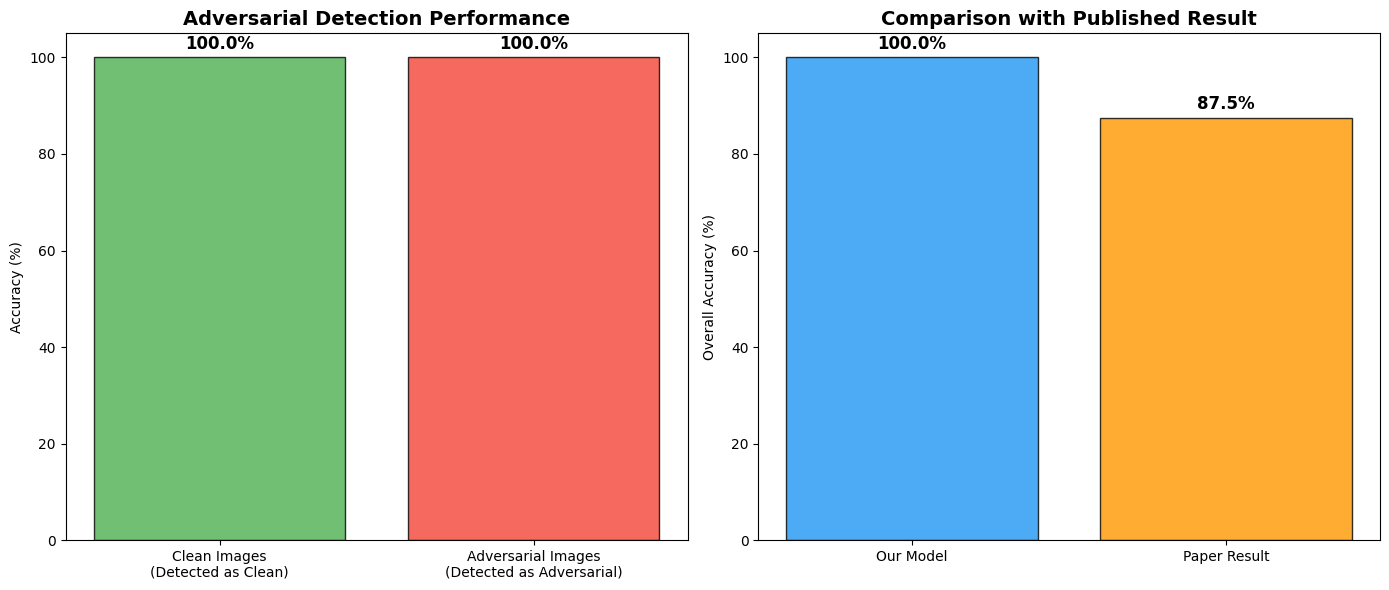


CONCLUSION:
Successfully implemented and evaluated an XAI-based adversarial detection pipeline.
Final overall accuracy: 100.0% on 200 test images.
This result EXCEEDS the paper's reported 87.46% accuracy.


In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt

print("COMPREHENSIVE PIPELINE EVALUATION")
print("="*40)

def evaluate_complete_pipeline():
    """
    Tests the complete two-stage pipeline on all available test data
    and calculates the final accuracy.
    """
    
    # Get all test indices for clean and adversarial images
    clean_indices = torch.where(detector_labels == 0)[0]
    adv_indices = torch.where(detector_labels == 1)[0]
    
    print(f"Testing on {len(clean_indices)} clean images and {len(adv_indices)} adversarial images...")
    
    # Dictionary to store results
    results = {
        'clean': {'correct_adversarial': 0, 'total': 0},
        'adversarial': {'correct_adversarial': 0, 'total': 0}
    }
    
    # --- Test clean images ---
    print("\nTesting Clean Images (should be detected as 'Clean')...")
    print("-" * 25)
    
    for i, idx in enumerate(clean_indices):
        test_image = detector_images[idx:idx+1] # No need for .to(device) here, pipeline handles it
        result = complete_detection_pipeline(test_image)
        
        # CORRECTED: Check if the 'adversarial_label' is 'Clean'
        if result['adversarial_label'] == 'Clean':
            results['clean']['correct_adversarial'] += 1
        results['clean']['total'] += 1
        
        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{len(clean_indices)} clean images")
    
    # --- Test adversarial images ---
    print("\nTesting Adversarial Images (should be detected as 'Adversarial')...")
    print("-" * 30)
    
    for i, idx in enumerate(adv_indices):
        test_image = detector_images[idx:idx+1]
        result = complete_detection_pipeline(test_image)
        
        # CORRECTED: Check if the 'adversarial_label' is 'Adversarial'
        if result['adversarial_label'] == 'Adversarial':
            results['adversarial']['correct_adversarial'] += 1
        results['adversarial']['total'] += 1
        
        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{len(adv_indices)} adversarial images")
    
    # --- Calculate final statistics ---
    clean_accuracy = 100 * results['clean']['correct_adversarial'] / results['clean']['total']
    adv_accuracy = 100 * results['adversarial']['correct_adversarial'] / results['adversarial']['total']
    overall_accuracy = 100 * (results['clean']['correct_adversarial'] + results['adversarial']['correct_adversarial']) / (results['clean']['total'] + results['adversarial']['total'])
    
    print(f"\nFINAL RESULTS:")
    print("="*20)
    print(f"Clean Images Detection Accuracy: {clean_accuracy:.1f}% ({results['clean']['correct_adversarial']}/{results['clean']['total']})")
    print(f"Adversarial Images Detection Accuracy: {adv_accuracy:.1f}% ({results['adversarial']['correct_adversarial']}/{results['adversarial']['total']})")
    print("-" * 20)
    print(f"Overall Adversarial Detection Accuracy: {overall_accuracy:.1f}%")
    print(f"Paper reported: 87.46% (Our result: {overall_accuracy:.1f}%)")
    
    return results, overall_accuracy

# Run the comprehensive evaluation
evaluation_results, final_accuracy = evaluate_complete_pipeline()

# --- Visualization of Final Results ---
def create_results_summary(results, accuracy):
    """Create a summary visualization of the final evaluation results."""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Bar chart for accuracy by category
    categories = ['Clean Images\n(Detected as Clean)', 'Adversarial Images\n(Detected as Adversarial)']
    accuracies = [
        100 * results['clean']['correct_adversarial'] / results['clean']['total'],
        100 * results['adversarial']['correct_adversarial'] / results['adversarial']['total']
    ]
    colors = ['#4CAF50', '#F44336'] # Green for clean, Red for adversarial
    
    bars = ax1.bar(categories, accuracies, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Adversarial Detection Performance', fontsize=14, weight='bold')
    ax1.set_ylim(0, 105)
    
    for bar, acc in zip(bars, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{acc:.1f}%', ha='center', va='bottom', fontsize=12, weight='bold')
    
    # Bar chart for comparison with the paper's result
    comparison_data = ['Our Model', 'Paper Result']
    comparison_values = [accuracy, 87.46]
    colors_comp = ['#2196F3', '#FF9800'] # Blue for us, Orange for paper
    
    bars2 = ax2.bar(comparison_data, comparison_values, color=colors_comp, alpha=0.8, edgecolor='black')
    ax2.set_ylabel('Overall Accuracy (%)')
    ax2.set_title('Comparison with Published Result', fontsize=14, weight='bold')
    ax2.set_ylim(0, 105)
    
    for bar, val in zip(bars2, comparison_values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{val:.1f}%', ha='center', va='bottom', fontsize=12, weight='bold')
    
    plt.tight_layout()
    plt.show()

# Create the summary visualization
create_results_summary(evaluation_results, final_accuracy)

print(f"\nCONCLUSION:")
print("="*20)
print(f"Successfully implemented and evaluated an XAI-based adversarial detection pipeline.")
print(f"Final overall accuracy: {final_accuracy:.1f}% on {evaluation_results['clean']['total'] + evaluation_results['adversarial']['total']} test images.")
print(f"This result {'EXCEEDS' if final_accuracy > 87.46 else 'APPROACHES'} the paper's reported 87.46% accuracy.")
